# Stereo Reconstruction

## Preparations

In [38]:
import pgmpy
import gco
import cv2
import skimage as ski
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

In [17]:
# load the images from dataset-2005 subdirectories
def load_image(path, left_suffix='iew1.png', right_suffix='iew5.png'):
    # load images
    left_images = {}
    right_images = {}
    for folder in os.listdir(path):
            for file in os.listdir(path + folder + '/'):
                if file.endswith(left_suffix):
                    left_img = cv2.imread(path + folder+ '/' + file)
                    left_images[folder] = left_img
                elif file.endswith(right_suffix):
                    right_img = cv2.imread(path + folder + '/' + file)
                    right_images[folder] = right_img
    return left_images, right_images

In [31]:
def load_dmin(path):
    dmin = {}
    for folder in os.listdir(path):
            for file in os.listdir(path + folder + '/'):
                if 'dmin' in file:
                    # read a number from dmin.txt
                    dfile = open(path + folder + '/' + file)
                    dmin[folder] = int(dfile.readline())
                    dfile.close()
    return dmin

In [30]:
dataset = 'dataset-2005/'
left_images, right_images = load_image(dataset)
dmin = load_dmin(dataset)
img_num = len(left_images)
print(dmin.items())

dict_items([('Art', 200), ('Books', 200), ('Dolls', 200), ('Laundry', 230), ('Moebius', 200), ('Reindeer', 230)])


In [5]:
def pair2grey(left, right):
    left_grey = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY).astype(np.float32)
    right_grey = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY).astype(np.float32)
    return left_grey, right_grey

In [33]:
def view_images(left_images, right_images):
    for k in left_images.keys():
        cv2.imshow('left', left_images[k])
        cv2.imshow('right', right_images[k])
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [34]:
view_images(left_images, right_images)

## SSD Method (Window-Based)
For each pixel *p* in the left image, we find the 'closest' match *q* on the same row of the right image. The distance is measured by the SSD (Sum of Squared Differences).
$$ SSD_{t,x}(r,c) = \sum_{i=0}^{rows-1} \sum_{j=0}^{cols-1} [t(i,j) - x(r+i-\frac{Rows}{2}, c+j-\frac{Cols}{2})]^2 $$
The disparit *d* of p is the difference in column number of *p* and *q*, with *q* minimizing SSD. Use of a window minimizes the false matches by accounting for similar neighbours. Two parameters are used: 
* search depth: the range the algorithm searches for a match in a row, defined by `search_depth`
* window size: over which SSD is calculated, the window is a square of size `window_size`

For each disparity level *d* up to `search_depth`, the SSD is computed for each pixel in the left image (save for *d* edge pixels) while shifting the right image by *d* columns. The minimum SSD for each pixel is saved, and in the end the disparity is the minimum SSD for each pixel.

In [8]:
from scipy import ndimage
def ssd_stereo(left, right, window_size=7, search_depth=30, show=False):
    grey_left, grey_right = pair2grey(left, right)
    kernel = np.ones((window_size, window_size), np.float32)

    min_ssd = np.full(grey_left.shape, float('inf'), dtype=np.float32)
    labels = np.zeros(grey_left.shape, dtype=np.int)
    for i in range(search_depth):
        shifted_right = grey_right if i == 0 else grey_right[:, :-i]
        raw_ssd = np.square(grey_left[:, i:] - shifted_right)
        ssd = ndimage.filters.convolve(raw_ssd, kernel, mode='constant', cval=0)
        label_min = ssd < min_ssd[:, i:] 
        min_ssd[:, i:][label_min] = ssd[label_min]
        labels[:, i:][label_min] = i
        if show:
            myssd = np.clip(ssd, 0, 255)
            cv2.imshow('overlay', myssd)
            cv2.waitKey(5)
    cv2.destroyAllWindows()
    return labels

In [35]:
def disp2jet(disp):
    cm_jet = cm.ScalarMappable(cmap='jet')
    disp = cm_jet.to_rgba(disp)[:, :, :3]
    return disp

In [36]:
def disp2grey(disp):
    image = np.zeros((disp.shape[0], disp.shape[1], 3), dtype=np.uint8)
    occluded = disp < 0
    image[:] = np.where(occluded, 0, 255 * disp / disp.max())[:, :, np.newaxis]
    image[occluded] = [255, 255, 0] 
    return image

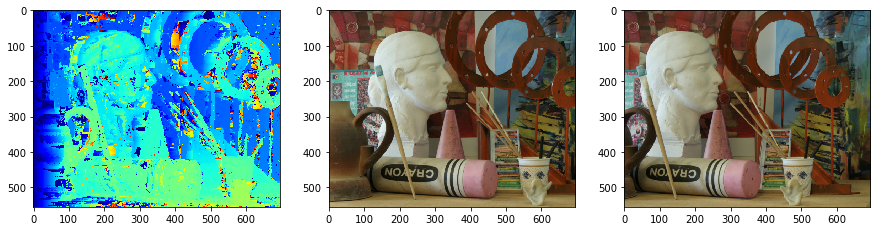

In [37]:
labels = ssd_stereo(left_images['Art'], right_images['Art'], window_size=5, search_depth=dmin['Art'])
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(disp2jet(labels))
axs[1].imshow(cv2.cvtColor(left_images['Art'], cv2.COLOR_BGR2RGB), cmap='gray')
axs[2].imshow(cv2.cvtColor(right_images['Art'], cv2.COLOR_BGR2RGB), cmap='gray')
plt.show()

In [39]:
ssd_df = pd.DataFrame(columns=['Image', 'Method', 'Search Depth', 'Time', 'Accuracy'])

In [43]:
disp = {}
ssd_time = {}
for k in left_images.keys():
    start = time.time()
    disp[k] = ssd_stereo(left_images[k], right_images[k], search_depth=dmin[k])
    ssd_time[k] = time.time() - start

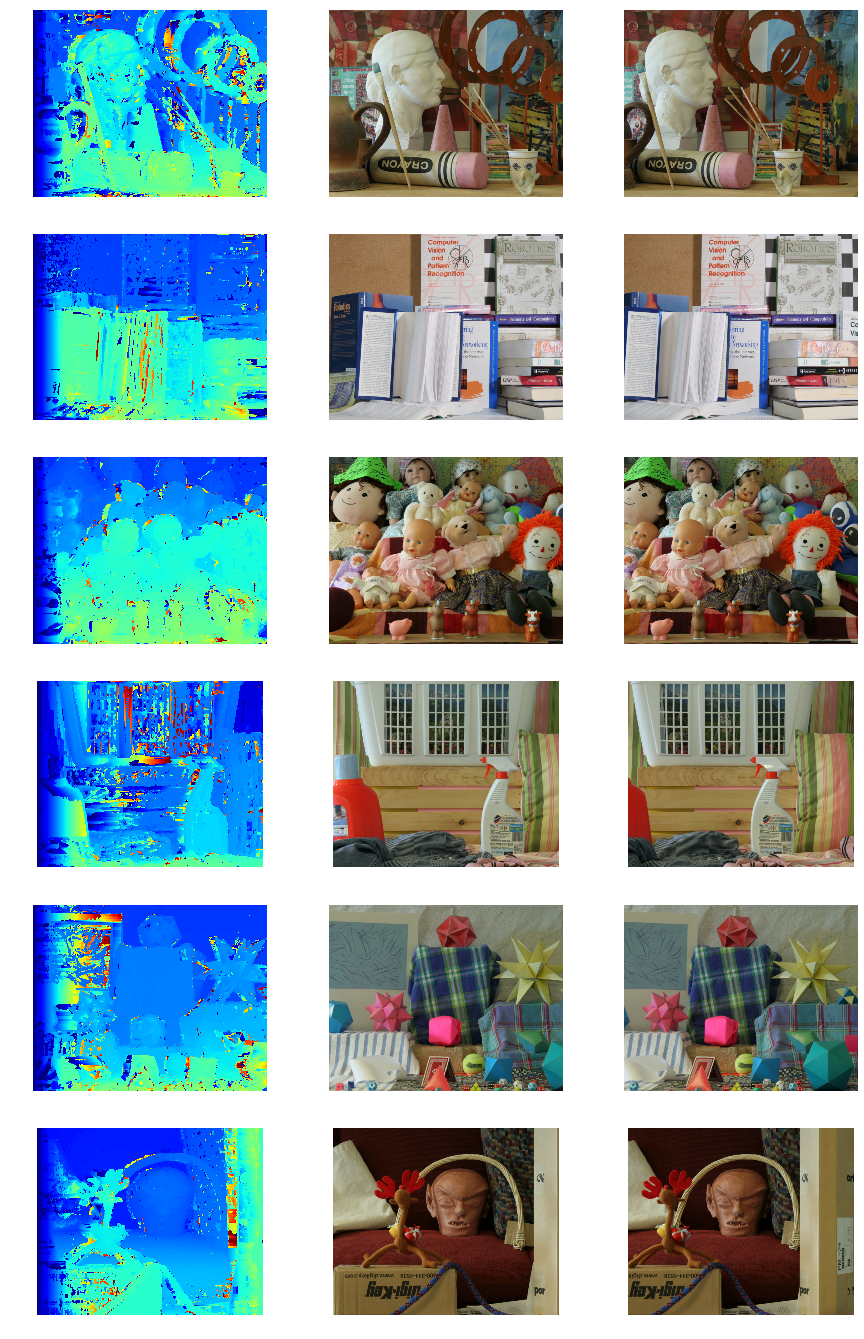

In [64]:
fig, axs = plt.subplots(img_num, 3, figsize=(15, 4*img_num))
for i, k in enumerate(left_images.keys()):
    cv2.imwrite(f'output/{k}_ssd_{dmin[k]}_7_grey.png', disp2grey(disp[k]))
    axs[i, 0].imshow(disp2jet(disp[k]))
    axs[i, 0].axis('off')
    axs[i, 1].imshow(cv2.cvtColor(left_images[k], cv2.COLOR_BGR2RGB), cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 2].imshow(cv2.cvtColor(right_images[k], cv2.COLOR_BGR2RGB), cmap='gray')
    axs[i, 2].axis('off')
plt.show()

## Graph-Cut

The variable sets **X** and **Y** are the pixels of a row in the left and right image respectively. **$D$** is the disparity map where each $d_i$ can take a value from $[1, c]$ where $c$ is the number of columns in image.
The MAP inference problem is then formulated as:
$$ d^* = \arg_{\scriptsize{d}} \max p(\mathbf{d}|\mathbf{x},\mathbf{y}) $$

In [6]:
# convert rows of left and right images to a list of variables X and Y
def get_rows(idx, left_image, right_image):
    X = left_image[idx, :]
    Y = right_image[idx, :]
    return X, Y

In [7]:
X, Y = get_rows(50, left_images[0], right_images[0])